Loading data

In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import neptune.new as neptune

In [2]:
CFG = {
    "n_epochs": 10,
    "optimizer": "adam",
    "lr": 0.01,
    "seed": 42,
    "batch_size": 8,

    "model": "custom",
    "n_hidden_layers": 2,
    "hidden_state": 32,
    "dropout_rate": 0.1,
}

In [3]:
run = neptune.init(
    project='cveatt/cveatt-onseo',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZDc4N2M0Zi02NDU2LTRkODYtODlmZC1jNTczNzVlMzQ5M2YifQ==',
)

https://app.neptune.ai/cveatt/cveatt-onseo/e/CVEAT-1
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [4]:
run['parameters'] = CFG

In [5]:
df = pd.read_csv("Iris.csv", index_col=0)
df.head(2)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa


Data preparating

In [6]:
df['target'] = df['Species'].map(
    {
        'Iris-setosa':0,
        'Iris-versicolor':1,
        'Iris-virginica':2,
    }
)
df.head(2)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,target
Id,,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa,0
2,4.9,3.0,1.4,0.2,Iris-setosa,0


In [7]:
feature_col = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
target_col = "target"
X = df[feature_col].values
y = df[target_col].values

X.shape, y.shape


((150, 4), (150,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=CFG["seed"], stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=CFG["seed"], stratify=y_test
)
X_train.shape, X_val.shape, X_test.shape

((90, 4), (30, 4), (30, 4))

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


DATA

In [10]:
class DataExtractor(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = torch.tensor(self.X[index], dtype=torch.float32)
        y = torch.tensor(self.y[index], dtype=torch.long) #long for int

        return {"X" : X, "y" : y}

In [11]:
train_data_extractor = DataExtractor(X_train, y_train)
valid_data_extractor = DataExtractor(X_val, y_val)
test_data_extractor = DataExtractor(X_test, y_test)

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_data_extractor,
    batch_size=CFG["batch_size"],
    shuffle=True,
)

valid_loader = torch.utils.data.DataLoader(
    valid_data_extractor,
    batch_size=CFG["batch_size"],
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    test_data_extractor,
    batch_size=CFG["batch_size"],
    shuffle=False,
)

MODEL

In [13]:
class LittleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = torch.nn.Linear(4, CFG["hidden_state"])

        hidden_layers = []
        for i in range(CFG["n_hidden_layers"]):
            hidden_layers.append(
                torch.nn.Linear(CFG["hidden_state"], CFG["hidden_state"])
                )
            hidden_layers.append(torch.nn.ReLU())
            hidden_layers.append(torch.nn.Dropout(CFG["dropout_rate"]))

        self.hidden_layers = torch.nn.Sequential(*hidden_layers)
            
        self.linear2 = torch.nn.Linear(CFG["hidden_state"], 3)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.hidden_layers(x)
        x = self.linear2(x)
        return(x)

In [14]:
model = LittleModel()
model

LittleModel(
  (linear1): Linear(in_features=4, out_features=32, bias=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)

TRAIN

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=CFG["lr"])
criterion = F.cross_entropy

In [16]:
history = {}

for epoch in range (CFG["n_epochs"]):
    time.sleep(10)
    print(f"Epoch: {epoch}")

    model.train() # dropout activation
    train_score = []
    train_loss = []
    for step, batch in enumerate(train_loader):
        batch_X = batch["X"]
        batch_y = batch["y"]

        optimizer.zero_grad()

        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()

        optimizer.step()

        train_loss.append(loss.detach().item())
        train_score.extend(
            np.argmax(y_pred.detach().numpy(), axis=1) == batch_y.numpy()
        )

    print(f"Train loss: {np.mean(train_loss):.5f}")
    run["train/loss"].log(np.mean(train_loss))
    print(f"Train score: {np.mean(train_score):.5f}")
    run["train/score"].log(np.mean(train_score))

    model.eval() # dropout deactivation
    valid_score = []
    valid_loss = []
    for step, batch in enumerate(valid_loader):
        batch_X = batch["X"]
        batch_y = batch["y"]

        with torch.no_grad():
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)

        valid_loss.append(loss.detach().item())
        valid_score.extend(
            np.argmax(y_pred.detach().numpy(), axis=1) == batch_y.numpy()
        )

    print(f"Valid loss: {np.mean(valid_loss):.5f}")
    run["valid/loss"].log(np.mean(valid_loss))
    print(f"Valid score: {np.mean(valid_score):.5f}")
    run["valid/score"].log(np.mean(valid_score))

    history["train_loss"] = history.get("train_loss", []) + [np.mean(train_loss)]
    history["train_score"] = history.get("train_score", []) + [np.mean(train_score)]
    history["valid_loss"] = history.get("valid_loss", []) + [np.mean(valid_loss)]
    history["valid_score"] = history.get("valid_score", []) + [np.mean(valid_score)]


Epoch: 0
Train loss: 0.88371
Train score: 0.71111
Valid loss: 0.55221
Valid score: 0.80000
Epoch: 1
Train loss: 0.41338
Train score: 0.85556
Valid loss: 0.35178
Valid score: 0.86667
Epoch: 2
Train loss: 0.23535
Train score: 0.88889
Valid loss: 0.29536
Valid score: 0.90000
Epoch: 3
Train loss: 0.21676
Train score: 0.91111
Valid loss: 0.48986
Valid score: 0.80000
Epoch: 4
Train loss: 0.17435
Train score: 0.93333
Valid loss: 0.13078
Valid score: 0.96667
Epoch: 5
Train loss: 0.17409
Train score: 0.95556
Valid loss: 0.14876
Valid score: 0.96667
Epoch: 6
Train loss: 0.08773
Train score: 0.96667
Valid loss: 0.13043
Valid score: 0.96667
Epoch: 7
Train loss: 0.08967
Train score: 0.96667
Valid loss: 0.16471
Valid score: 0.93333
Epoch: 8
Train loss: 0.04968
Train score: 0.97778
Valid loss: 0.13412
Valid score: 0.93333
Epoch: 9
Train loss: 0.06240
Train score: 0.97778
Valid loss: 0.08674
Valid score: 0.96667


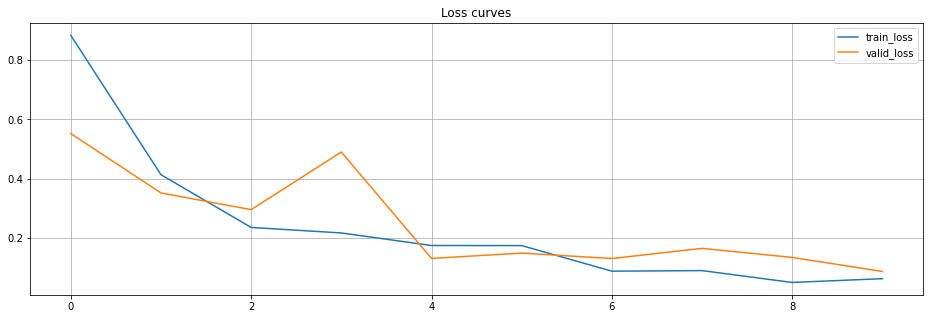

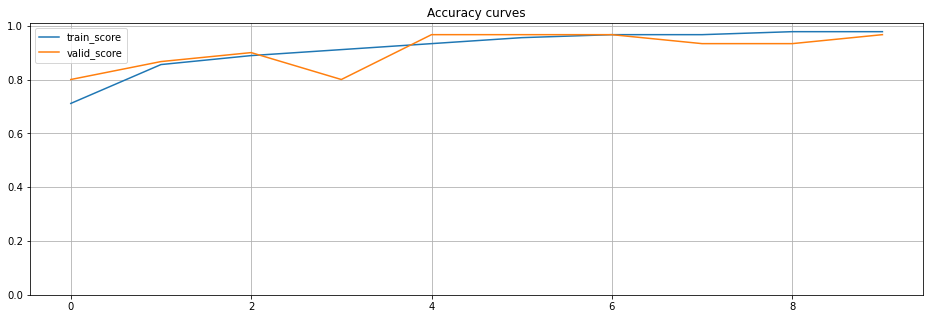

In [17]:
fig = plt.figure(figsize=(16, 5))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["valid_loss"], label="valid_loss")
plt.title("Loss curves")
plt.grid()
plt.legend()
plt.show()

run["figures"].log(fig)

fig = plt.figure(figsize=(16, 5))
plt.plot(history["train_score"], label="train_score")
plt.plot(history["valid_score"], label="valid_score")
plt.title("Accuracy curves")
plt.ylim(0, 1.01)
plt.grid()
plt.legend()
plt.show()

run["figures"].log(fig)

In [18]:
model.eval()
test_score = []
test_loss = []

for step, batch in enumerate(test_loader):
    batch_X = batch["X"]
    batch_y = batch["y"]

    with torch.no_grad():
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)

    test_loss.append(loss.detach().item())
    test_score.extend(
        np.argmax(y_pred.detach().numpy(), axis=1) == batch_y.numpy()
    )

print(f"Test loss: {np.mean(test_loss):.5f}")
run["test/loss"].log(np.mean(test_loss))
print(f"Test score: {np.mean(test_score):.5f}")
run["test/score"].log(np.mean(test_score))

Test loss: 0.03585
Test score: 1.00000


In [19]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!
